In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns


drive.mount('/content/drive', force_remount=True)
PATH = '/content/drive/MyDrive/Datasets/bc_preproc.csv'

bc_df = pd.read_csv(PATH)

Mounted at /content/drive


In [ ]:
aux = pd.concat([bc_df.iloc[:3, :], bc_df.iloc[-4:, :]], ignore_index=True)
aux

,Race,T Stage,N Stage,6th Stage,Grade,Estrogen Status,Progesterone Status,Status
0,0.411342,-1.112622,-0.775705,-1.172801,1.205944,0.351361,0.552265,1
1,0.411342,0.126533,0.495869,0.264806,-0.333040,0.351361,0.552265,1
2,0.411342,1.365689,1.767443,1.702413,-0.333040,0.351361,0.552265,1
3,0.411342,-1.112622,-0.775705,-1.172801,1.205944,0.351361,0.552265,0
4,0.411342,-1.112622,-0.775705,-1.172801,1.205944,-2.846073,-1.810723,0
5,0.411342,1.365689,1.767443,1.702413,1.205944,0.351361,0.552265,0
6,0.411342,1.365689,1.767443,1.702413,1.205944,0.351361,0.552265,0


## Paso 1. Calcular las prior probabilities P(Alive), P(Deceased)

In [ ]:
def prior_p(dataframe):
  prior_p = dataframe['Status'].value_counts().agg(lambda x: x/dataframe.shape[0], axis=0)
  prior_ps = pd.DataFrame(prior_p).rename(columns={'Status': 'Prior Probability'})
  prior_ps['Status'] = prior_p.index.map({1: 'P(Alive)', 0: 'P(Deceased)'})
  return prior_ps

## Paso 2. Calcular el Likelihood con el M-estimator

### 2.1. Calcular los valores de p

In [ ]:
def p_val(dataframe):
  p_v = [(1 / dataframe[column].nunique()) for column in dataframe.columns[:-1]]
  p_dic = {column: p_v[i] for i, column in enumerate(dataframe.columns[:-1])}
  p_df = pd.DataFrame(data = [p_dic], index=[0])
  return p_df

### 2.2 Fijar m y n

In [ ]:
def mn_val(dataframe):
  m = dataframe['Status'].nunique()
  n = [dataframe[dataframe['Status'] == val].shape[0] for val in np.arange(m)]
  return m, n

In [ ]:
mn_val(bc_df)

(2, [3408, 3408])

### 2.3 Calcular n' y n'+mp / n+m

In [ ]:
def m_estimate(input_vector, dataframe):
  dic = {}

  # Sección 1: Calcular n prima
  for target_value in dataframe['Status'].unique()[::-1]: # Para cada valor único de la column status (la lista dada la vuelta para luego ahcer el dataframe bien)
    for i, column in enumerate(dataframe.columns[:-1]): # Por cada columna y su índice exceptuando la última columna
      n_prime = (dataframe[dataframe['Status'] == target_value][column] == input_vector[i]).sum() # Para cada valor dentro de las filas del valor target, cuenta las que sean igual al valor del input vector
      if column not in dic:
        dic[column] = [] # Si es la primera vez que se itera sobre esta columna, se añade al diccionario
      dic[column].append(n_prime) # Le añadimos el valor calculado a la columna correspondiente

  # Sección 2: Calcular likelihood con m-estimate
  df = pd.DataFrame(data=dic)
  # print(df.to_latex(index=False, float_format="{:.1f}".format, ))
  m, n = mn_val(dataframe) # Calculamos m y n
  p = p_val(dataframe) # Calculamos los valores de p
  p = p.iloc[0]  # Convert the DataFrame to a Series for easier arithmetic operations
  # For each unique value of 'Status'
  for i in range(len(n)):
    # Applying the formula to calculate m_estimate for each row in df
    m_estimate = df.apply(lambda x: (x + m * p) / (m + n[i]), axis=1)


  return m_estimate

## 3. Cálculo de la probabilidad posterior

In [ ]:
def posterior_probs(input_vector, dataframe):
  # Section 1: Get the m_estimate likelihood
  m_estimate_final = m_estimate(input_vector, dataframe)

  likelihood_deceased = np.prod(m_estimate_final.iloc[0, :].values).astype(np.float16)
  likelihood_alive = np.prod(m_estimate_final.iloc[1, :].values).astype(np.float16)
  # Section 2: Get the prior probs
  prior_probs = prior_p(dataframe)

  prior_alive = prior_probs.iloc[1, 0].astype(np.float16)
  prior_deceased = prior_probs.iloc[0, 0].astype(np.float16)

  denominator = prior_alive * likelihood_alive + prior_deceased * likelihood_deceased

  numerator_deceased = prior_deceased * likelihood_deceased
  numerator_alive = prior_alive * likelihood_alive

  posterior_alive = numerator_alive / denominator
  posterior_deceased = numerator_deceased / denominator

  final = pd.DataFrame({
      'P(Alive | x)': posterior_alive,
      'P(Deceased | x)': posterior_deceased
  }, index = [0])

  return final

In [ ]:
print(posterior_probs(bc_df.iloc[15, :].values.tolist(), bc_df).to_latex(index=False, float_format="{:.1f}".format, ))


\begin{tabular}{rr}
\toprule
 P(Alive | x) &  P(Deceased | x) \\
\midrule
          0.8 &              0.2 \\
\bottomrule
\end{tabular}



<ipython-input-212-5d826a047ad5>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(posterior_probs(bc_df.iloc[15, :].values.tolist(), bc_df).to_latex(index=False, float_format="{:.1f}".format, ))


In [ ]:
0.01907/0.02444

0.780278232405892

In [ ]:
predictions = pd.DataFrame(columns=['P(Alive | x)', 'P(Deceased | x)', 'Actual Status'])

for i in range(bc_df.shape[0]):
    input_vector = bc_df.iloc[i, :-1].values.tolist()
    actual_status = bc_df.iloc[i, -1]

    # Calcular las probabilidades posteriores
    posterior = posterior_probs(input_vector, bc_df)

    # Agregar el estado real al DataFrame de probabilidades posteriores
    posterior['Actual Status'] = actual_status

    # Usar pd.concat para añadir la nueva fila al DataFrame de predicciones
    predictions = pd.concat([predictions, posterior.reset_index(drop=True)], ignore_index=True)


predictions

,P(Alive | x),P(Deceased | x),Actual Status
0,0.838867,0.161499,1
1,0.492432,0.507812,1
2,0.084961,0.914551,1
3,0.838867,0.161499,1
4,0.640137,0.359863,1
...,...,...,...
6811,0.336182,0.664062,0
6812,0.838867,0.161499,0
6813,0.306641,0.692871,0
6814,0.044525,0.955566,0


In [ ]:
predictions.to_csv('/content/drive/MyDrive/Datasets/predictions.csv', index=False)

In [ ]:
predictions2 = pd.DataFrame(columns=['P(Alive | x)', 'P(Deceased | x)', 'Actual Status'])

for i in range(20):
    input_vector = bc_df.iloc[i, :-1].values.tolist()
    actual_status = bc_df.iloc[i, -1]

    # Calcular las probabilidades posteriores
    posterior = posterior_probs(input_vector, bc_df)

    # Agregar el estado real al DataFrame de probabilidades posteriores
    posterior['Actual Status'] = actual_status

    # Usar pd.concat para añadir la nueva fila al DataFrame de predicciones
    predictions2 = pd.concat([predictions2, posterior.reset_index(drop=True)], ignore_index=True)


predictions2

,P(Alive | x),P(Deceased | x),Actual Status
0,0.838867,0.161499,1
1,0.492432,0.507812,1
2,0.084961,0.914551,1
3,0.838867,0.161499,1
4,0.640137,0.359863,1
5,0.912109,0.088135,1
6,0.957520,0.042267,1
7,0.021103,0.979004,1
8,0.086426,0.913574,1
9,0.062500,0.937500,1


In [ ]:
bc_df.iloc[15, :].values.tolist()

[0.4113418143486498,
 0.1265334417588367,
 -0.7757048514606538,
 -0.4539978736585269,
 -0.3330400462088183,
 0.351361288751662,
 0.5522654507456591,
 1.0]

In [ ]:
# Inicializar contadores para TP, TN, FP, FN
TP, TN, FP, FN = 0, 0, 0, 0

# Umbral para la clasificación
threshold = 0.5

# Iterar a través del DataFrame de predicciones para contar TP, TN, FP, FN
for i, row in predictions.iterrows():
    predicted_alive = row['P(Alive | x)'] >= threshold
    actual_alive = row['Actual Status'] == 'Alive'

    if predicted_alive and actual_alive:
        TP += 1
    elif not predicted_alive and not actual_alive:
        TN += 1
    elif predicted_alive and not actual_alive:
        FP += 1
    elif not predicted_alive and actual_alive:
        FN += 1

# Calcular la precisión (accuracy)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f'Accuracy: {accuracy}\n')
print(TP, TN, FP, FN)

Accuracy: 0.46332159624413144

0 3158 3658 0


True Positives (TP): 2376
True Negatives (TN): 2126
False Positives (FP): 1282
False Negatives (FN): 1032
Accuracy: 0.6605046948356808
Precision: 0.6495352651722253
Recall (Sensitivity): 0.6971830985915493
F1 Score: 0.6725162751202943


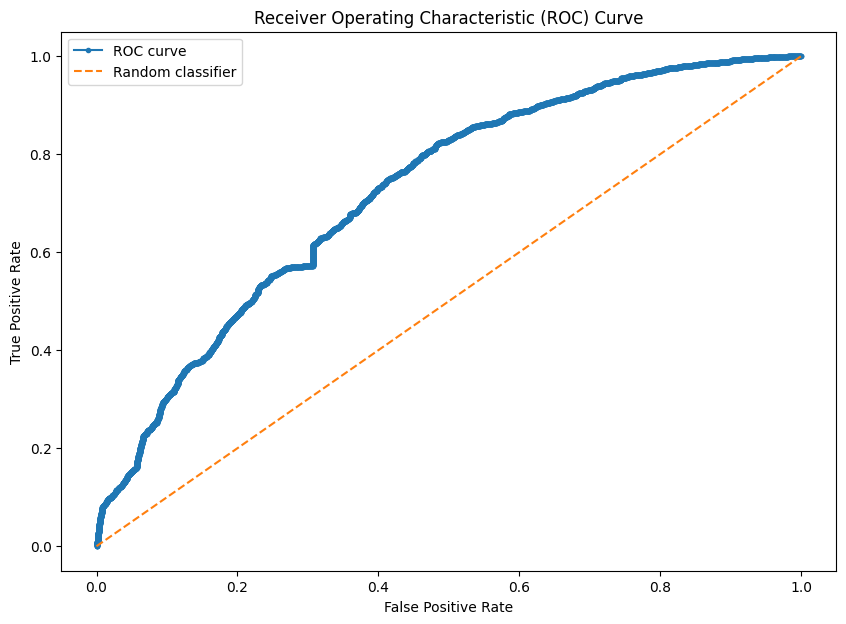

In [ ]:
# Initialize counters for TP, TN, FP, FN
TP = 0
TN = 0
FP = 0
FN = 0

# Initialize lists to store True Positive Rates and False Positive Rates for the ROC curve
tpr_list = []
fpr_list = []

# Threshold for classification
threshold = 0.5

# Calculate total number of positive and negative samples for ROC curve
total_positives = (predictions['Actual Status'] == 1).sum()
total_negatives = (predictions['Actual Status'] == 0).sum()

# Sort the DataFrame by the 'P(Alive | x)' column in descending order for ROC curve
sorted_predictions = predictions.sort_values(by='P(Alive | x)', ascending=False)

# Initialize counters for TP, FP for ROC curve
roc_TP = 0
roc_FP = 0

# Calculate TPR and FPR for each threshold for ROC curve
for i, row in sorted_predictions.iterrows():
    if row['Actual Status'] == 1:
        roc_TP += 1
    else:
        roc_FP += 1
    tpr = roc_TP / total_positives
    fpr = roc_FP / total_negatives
    tpr_list.append(tpr)
    fpr_list.append(fpr)

# Iterate through the DataFrame of predictions to count TP, TN, FP, FN
for i, row in predictions.iterrows():
    predicted_alive = row['P(Alive | x)'] >= threshold
    actual_alive = row['Actual Status'] == 1

    if predicted_alive and actual_alive:
        TP += 1
    elif not predicted_alive and not actual_alive:
        TN += 1
    elif predicted_alive and not actual_alive:
        FP += 1
    elif not predicted_alive and actual_alive:
        FN += 1

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate Precision
if TP + FP == 0:
    precision = 0
else:
    precision = TP / (TP + FP)

# Calculate Recall (Sensitivity)
if TP + FN == 0:
    recall = 0
else:
    recall = TP / (TP + FN)

# Calculate F1 Score
if precision + recall == 0:
    f1_score = 0
else:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Print the calculated metrics
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"F1 Score: {f1_score}")

# Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_list, tpr_list, marker='.', label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

